In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
import tensorboard
from torch.utils.tensorboard import SummaryWriter
import os
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from NN_MultiLayer import NeuralNetwork_MultiLayer # NN_MultiLayer.py in wkdir
from NN_SingleLayer import NeuralNetwork_SingleLayer # NN_SingleLayer.py in wkdir
from itertools import chain
import warnings
warnings.filterwarnings("ignore")

# Background
Our research team is interested in creating an automatic method to detect the risk of cancer using high throughput data obtained after sequencing liver cells. They collected data from 10,000 subjects, half of which developed cancer at some point during their lives. All sequencing data was summarized in only 500 variables. The datasets were divided between training (to build a classification model), validation (to obtain insight potential overfitting to the training data) and test (to evaluate model performance on an independent dataset)

# Goals

1. To build and evaluate the performance of a linear classification model (e.g., linear SVM, logistic regression). Please, provide the accuracy, sensitivity, specificity and probability distributions on the training, validation and tests datasets. Discuss any potential differences between the datasets.
<br><br>
2. To build and evaluate the performance of a fully connected neural network with: (i) only one layer of perceptrons and (ii) more than one layer of perceptrons. Please, provide the accuracy, sensitivity, specificity and probability distributions on the training, validation and tests datasets. Discuss any potential differences between the datasets.
<br><br>
3. Quantify and discuss the differences in performance between the linear classification model, the neural network with one single layer and the more complex neural network. Please, provide clear explanations about the observed differences and similarities.  

# Import, Separate & Scale Data

In [2]:
# Reading datasets
trainingData = pd.read_excel('./GeneExpressionCancer_training.xlsx').to_numpy()
trainingLabels = trainingData[:,-1]
trainingData = trainingData[:,:-1]

validationData = pd.read_excel('./GeneExpressionCancer_validation.xlsx').to_numpy()
validationLabels = validationData[:,-1]
validationData = validationData[:,:-1]

testData = pd.read_excel('./GeneExpressionCancer_test.xlsx').to_numpy()
testLabels = testData[:,-1]
testData = testData[:,:-1]

# Normalizing features
scaler = sklearn.preprocessing.StandardScaler()
trainingData = scaler.fit_transform(trainingData)
validationData = scaler.transform(validationData)
testData = scaler.transform(testData)

# Linear Classifier
Choosing logistic regression as the linear classifier here.

In [3]:
# Train logistic regression model
logisticReg = LogisticRegression()
logisticReg.fit(trainingData, trainingLabels)

# Make predictions on validation set
validation_yPred = logisticReg.predict(validationData)
validation_yScore = logisticReg.predict_proba(validationData)[:,1]

# Make predictions on test set
test_yPred = logisticReg.predict(testData)
test_yScore = logisticReg.predict_proba(testData)[:,1]

In [4]:
def performance_eval(y_true, y_pred):
    '''
    Function to evaluate performance of a binary classifier
    
    Inputs:
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained model)
        
    Outputs:
        Accuracy, Sensitivity and Specificity
    '''
    
    # Calculate sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Print accuracy, sensitivity and specificity
    print(f'Accuracy:    {round(accuracy_score(y_true, y_pred), 3)}')
    print(f'Sensitivity: {round(sensitivity, 3)}')
    print(f'Specificity: {round(specificity, 3)}\n')
    

def plot_roc_curve(y_true, y_score, label):
    '''
    Function to display ROC curve and AUC from classifier
    
    Inputs:
        y_true: True values of targets
        y_score: Target scores (probability estimates of the positive class)
        
    Outputs:
        ROC curve with AUC score reported
    '''
    
    # ROC, AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    
    # ROC Curve
    plt.plot(fpr, tpr, marker='.', label=f'{label} (AUC = {round(auc, 3)})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    

## Performance evaluation
The logistic regression classifier predictions are centered around 0.5 which indicates that most class predictions could go either way. It doesn't appear that this classifier is able to distinguish classes well. There doesn't appear to be any large differences between predictions on the validation and test sets.

### Validation Set

Accuracy:    0.508
Sensitivity: 0.486
Specificity: 0.53



<AxesSubplot:>

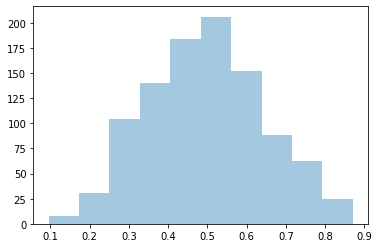

In [5]:
# Validation Set
performance_eval(y_true=validationLabels, y_pred=validation_yPred)
sns.distplot(validation_yScore, hist=True, kde=False, bins=10)

### Test Set

Accuracy:    0.527
Sensitivity: 0.535
Specificity: 0.518



<AxesSubplot:>

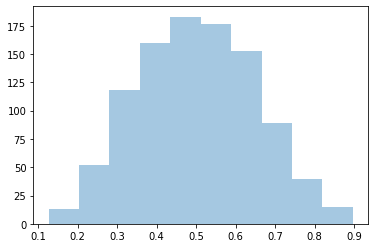

In [6]:
performance_eval(y_true=testLabels, y_pred=test_yPred)
sns.distplot(test_yScore, hist=True, kde=False, bins=10)

### ROC Curves

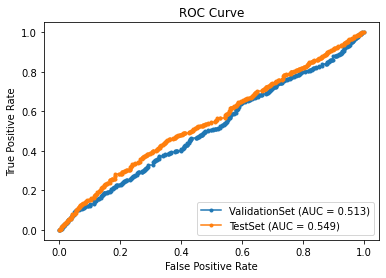

In [7]:
plot_roc_curve(y_true=validationLabels, y_score=validation_yScore, label="ValidationSet")
plot_roc_curve(y_true=testLabels, y_score=test_yScore, label="TestSet")

# Neural Networks
Networks are built in separate .py files that are located within the working directory.

## Single Perceptron Layer NN

In [8]:
# Remove logs from previous runs
os.system('rm -rf runs/*')

# Load the tensorboard notebook extension
%load_ext tensorboard

In [9]:
# Instantiate
nn_singleLayer = NeuralNetwork_SingleLayer(nFeatures=trainingData.shape[1])

# Train
nn_singleLayer.trainModel(
    trainingFeatures=trainingData, 
    trainingLabels=trainingLabels, 
    validationFeatures=validationData, 
    validationLabels=validationLabels)

In [10]:
%tensorboard --logdir=runs

In [11]:
# Test data
# Predicted probabilities
sL_yScore = nn_singleLayer.predict(features=testData, proba=True)
sL_yScore = list(chain(*sL_yScore.tolist()))

# Predicted classes
sL_predClass = nn_singleLayer.predict(features=testData, proba=False)
sL_predClass = list(chain(*sL_predClass.tolist()))

## Multilayer NN

In [12]:
# Remove logs from previous runs
os.system('rm -rf runs/*')

# Load the tensorboard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
# Instantiate
nn_multiLayer = NeuralNetwork_MultiLayer(nFeatures=trainingData.shape[1])

# Train
nn_multiLayer.trainModel(
    trainingFeatures=trainingData, 
    trainingLabels=trainingLabels, 
    validationFeatures=validationData, 
    validationLabels=validationLabels)

In [14]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 15135), started 0:00:10 ago. (Use '!kill 15135' to kill it.)

In [15]:
# Test data
# Predicted probabilities
mL_yScore = nn_multiLayer.predict(features=testData, proba=True)
mL_yScore = list(chain(*mL_yScore.tolist()))

# Predicted classes
mL_predClass = nn_multiLayer.predict(features=testData, proba=False)
mL_predClass = list(chain(*mL_predClass.tolist()))

## Neural Network Performance Evaluation

### Single Perceptron Layer NN
The single perceptron layer NN is essentially reproducing the results of the logistic regression classifier, which makes sense conceptually. With no hidden layers we are having the NN predict classes from the full feature set.

Accuracy:    0.527
Sensitivity: 0.527
Specificity: 0.527



<AxesSubplot:>

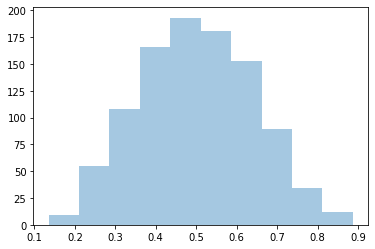

In [16]:
performance_eval(y_true=testLabels, y_pred=sL_predClass)
sns.distplot(sL_yScore, hist=True, kde=False, bins=10)

### Multilayer NN
Much better performance is seen here all around when we include a hidden layer. The predicted probability distribution shows that the classifier is giving more confident answers, and correctly too.

Accuracy:    0.92
Sensitivity: 0.971
Specificity: 0.867



<AxesSubplot:>

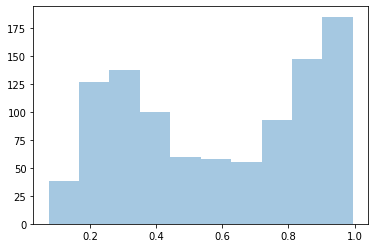

In [17]:
performance_eval(y_true=testLabels, y_pred=mL_predClass)
sns.distplot(mL_yScore, hist=True, kde=False, bins=10)

### ROC Comparison of All Models
Wow - the multilayer network is the best classifier I've seen in the class so far!

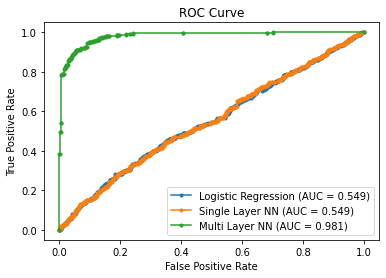

In [18]:
plot_roc_curve(y_true=testLabels, y_score=test_yScore, label="Logistic Regression")
plot_roc_curve(y_true=testLabels, y_score=sL_yScore, label="Single Layer NN")
plot_roc_curve(y_true=testLabels, y_score=mL_yScore, label="Multi Layer NN")